In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
%matplotlib notebook
plt.rcParams.update({'font.size': 16})
from XRaySimulation import util, Pulse, misc, Crystal, GetCrystalParam, MultiDevice
from XRaySimulation.GPU import GPUMultiDevice, GPUContrast
from utilities import *

# Create a Gaussian electric field 

The wavelength is 0.06 nm
It takes 2.14 seconds to produce the initial electric field.
Plotting Electric Field


<IPython.core.display.Javascript object>


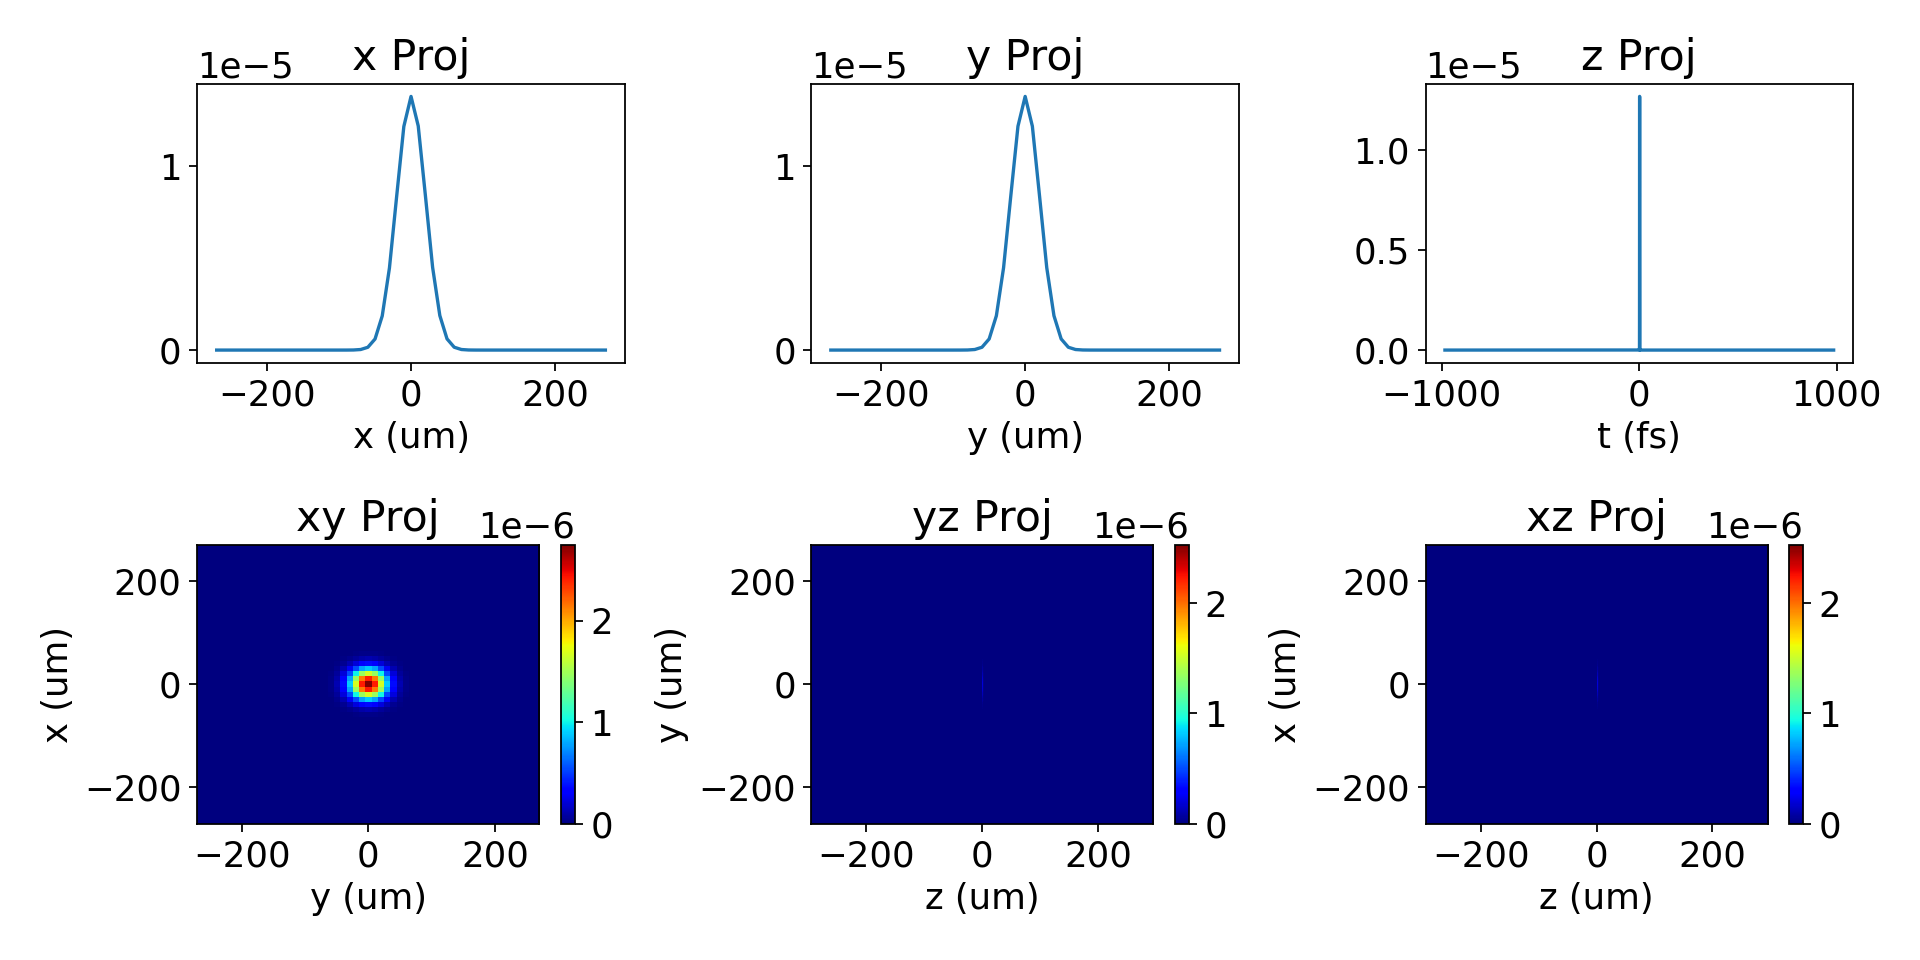

Plotting Electric Field Spectrum


<IPython.core.display.Javascript object>


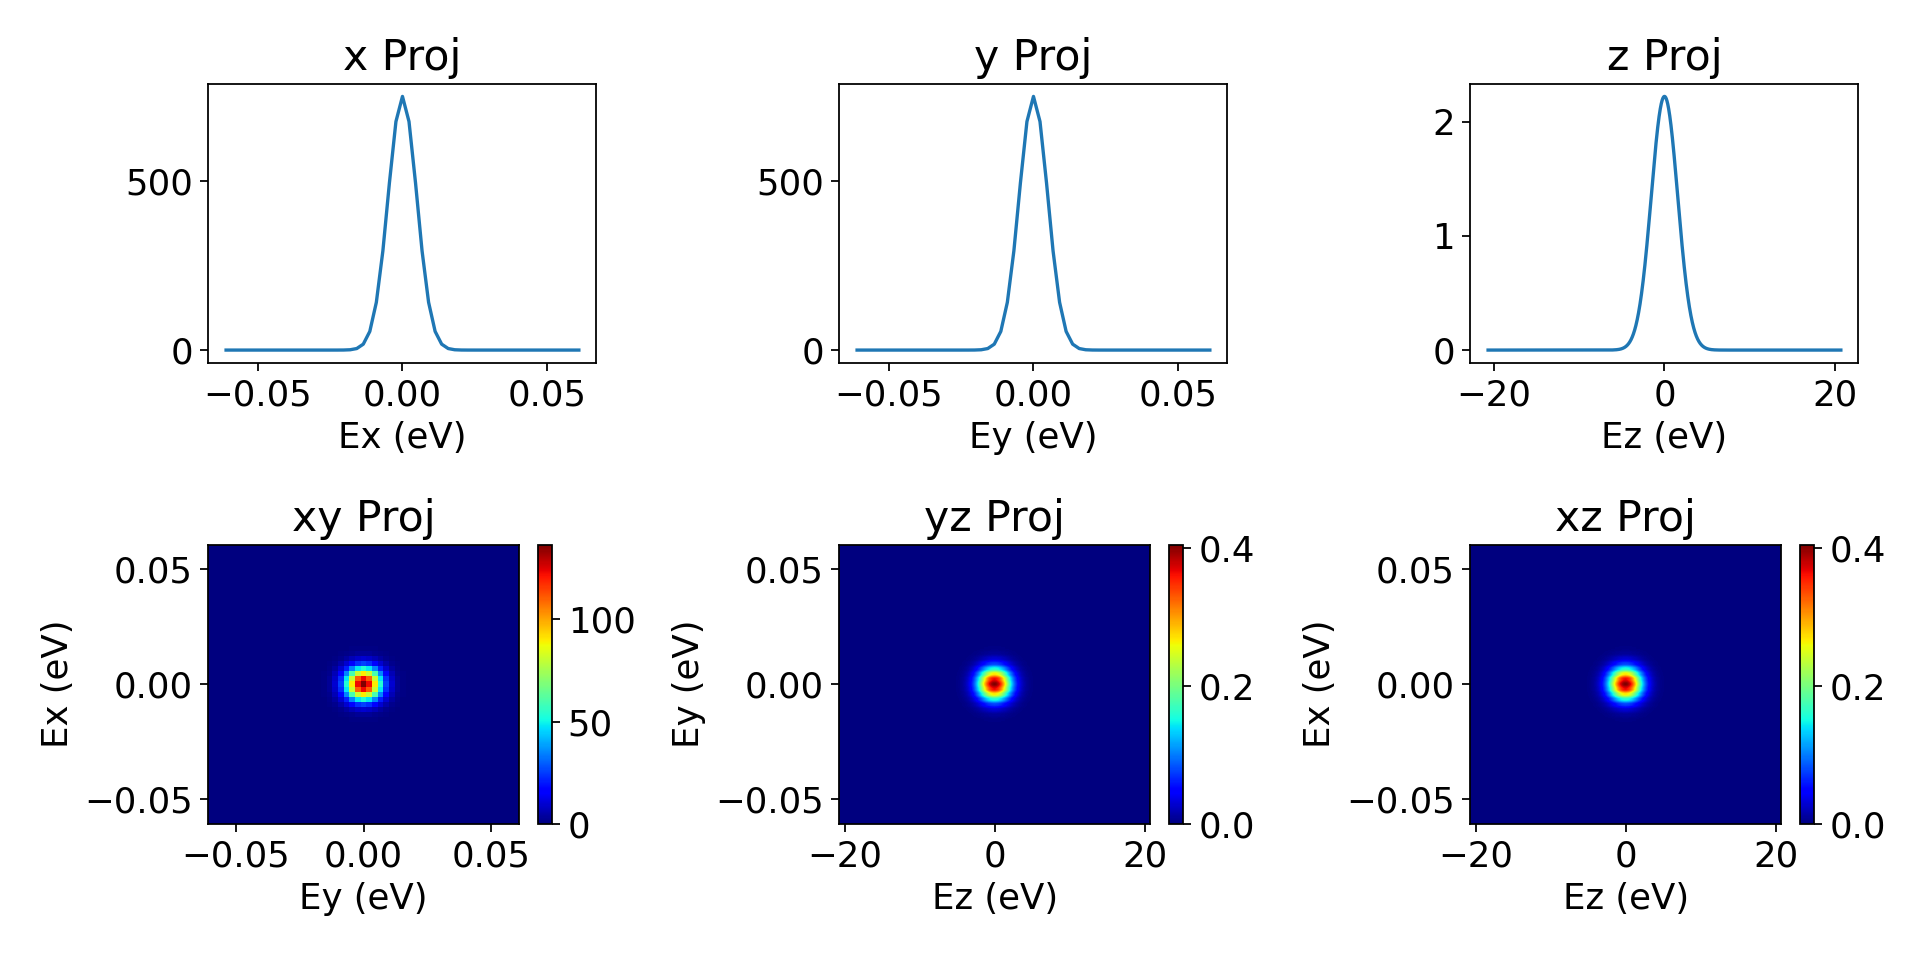

input beam bandwidth 3.6458380535583563 eV


In [2]:
# Spatial resolution along the x,y,z directions
dx = 10.0  # um
dy = 10.0  # um
dz = 0.1 * util.c  # 0.1fs * speed of light

# Define the size 
nx = 3 ** 3*2+1# pixel number along x
ny = 3 ** 3*2+1   # pixel number along y

nz = 3 ** 9    # pixel number along z

xCoor = np.arange(-nx // 2 + 1, nx - nx // 2) * dx
yCoor = np.arange(-ny // 2 + 1, ny - ny // 2) * dy
zCoor = np.arange(-nz // 2 + 1, nz - nz // 2) * dz
tCoor = zCoor / util.c

# Define the central wavelength
E0 = 20.0  # keV
k0 = util.kev_to_wavevec_length(E0)   # um^-1
wavelength0 = np.pi * 2 / k0
print("The wavelength is {:.2f} nm".format(1000 * wavelength0))

# Get k mesh
kxCoor = np.fft.fftshift(np.fft.fftfreq(nx, d=dx) * 2 * np.pi)
kyCoor = np.fft.fftshift(np.fft.fftfreq(ny, d=dy) * 2 * np.pi)
kzCoor = np.fft.fftshift(np.fft.fftfreq(nz, d=dz) * 2 * np.pi)
kzCoor += k0

# Convert wavevector to photon energy for illustration
ExCoor = util.wavevec_to_kev(kxCoor)
EyCoor = util.wavevec_to_kev(kyCoor)
EzCoor = util.wavevec_to_kev(kzCoor - k0)
dEz = np.diff(EzCoor)[0]*1000 #in eV
#################################################
#            Create the Pulse
#      With the SASE mean, we simply load and parse
#      the dfl file
#################################################
tic = time.time()
eFieldInitial = Pulse.getGaussianModeSum(nx = nx,
                                         ny = ny,
                                         nz = nz,
                                         dx = dx,
                                         dy = dy,
                                         dz = dz,
                                         nGaussian=int(1),  # number of Gaussian mode
                                         modeSizeX=20*np.sqrt(2),  # Size of Gaussian mode, sigma of electric field, which is sqrt(2)*sigma of intensity
                                         modeSizeY=20*np.sqrt(2), 
                                         modeSizeZ= 0.3 * util.c,
                                         modeCenterSpreadX=0.1,  # Spread of the center of the Gaussian mode
                                         modeCenterSpreadY=0.1,
                                         modeCenterSpreadZ=3.5 * util.c,
                                         k0=k0,   # central wave-vector length
                                         randomSeed=4)
toc = time.time()
print("It takes {:.2f} seconds to produce the initial electric field.".format(toc - tic))

# Get statistics of the efield
eFieldInitialStatistics = misc.get_statistics(np.square(np.abs(eFieldInitial)))
eSpectrumInitial = np.fft.fftshift(np.fft.fftn(eFieldInitial))
eSpectrumInitialStatistics = misc.get_statistics(np.square(np.abs(eSpectrumInitial)))
plotting = True
if plotting == True:
    plotting_e_beam(eFieldInitialStatistics, eSpectrumInitialStatistics, xCoor, yCoor, zCoor, tCoor, ExCoor, EyCoor, EzCoor)
dE_initial = fit_bandwidth(eSpectrumInitialStatistics)*dEz
print ("input beam bandwidth {} eV".format(dE_initial))

# upstream optics,  collimating and telescope setup

Plotting Electric Field


<IPython.core.display.Javascript object>


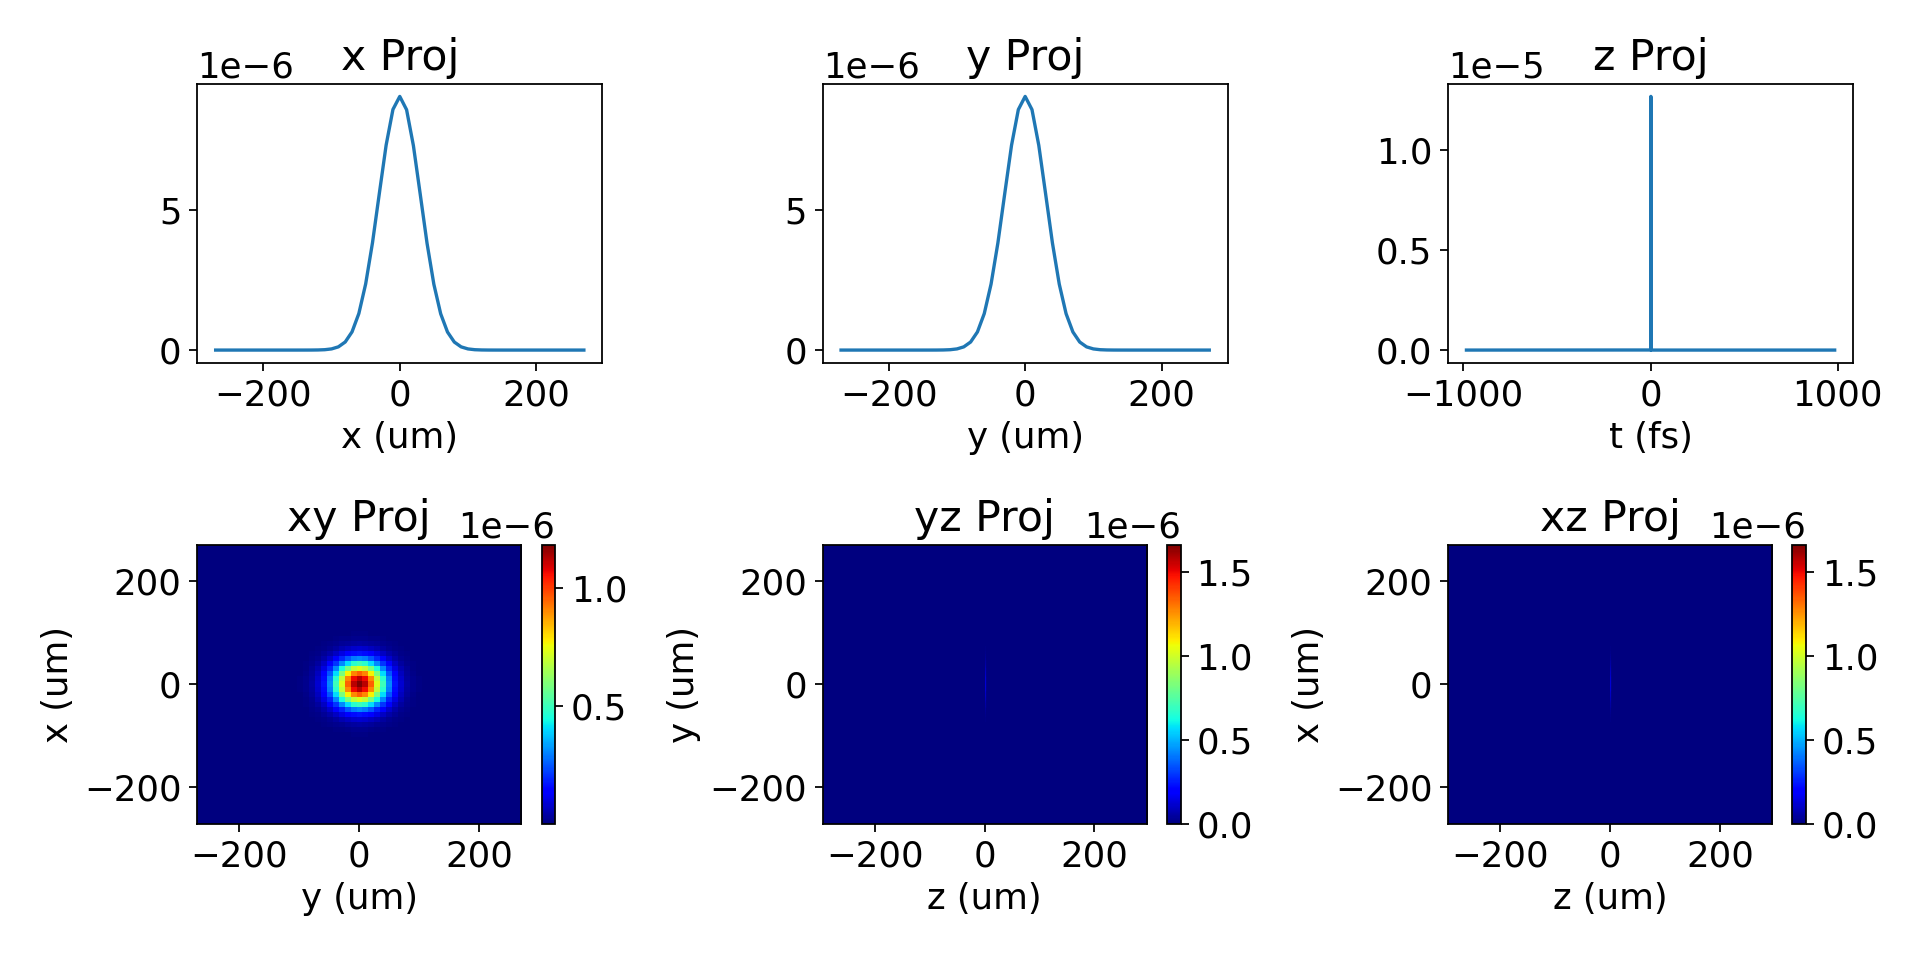

Plotting Electric Field Spectrum


<IPython.core.display.Javascript object>


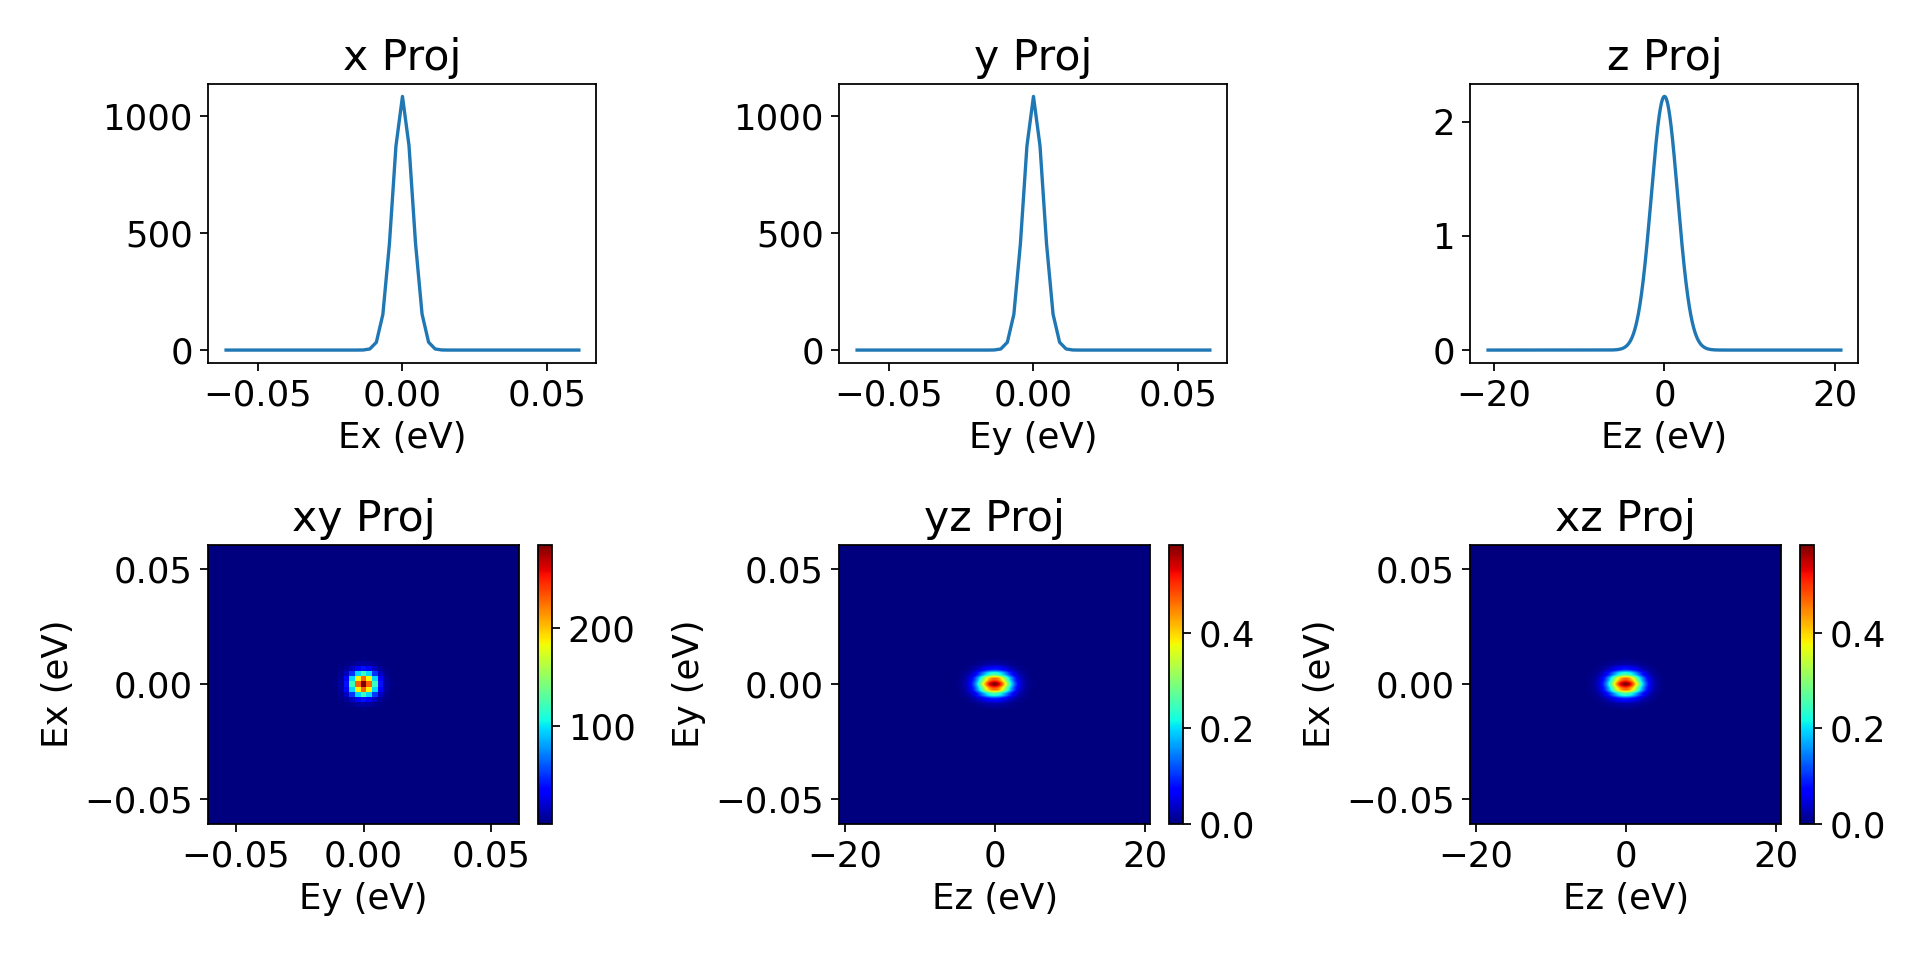

In [3]:
#propogration
# Get frequency
omega = np.zeros((nx, ny, nz))
omega += np.square(kxCoor[:, np.newaxis, np.newaxis])
omega += np.square(kyCoor[np.newaxis, :, np.newaxis])
omega += np.square(kzCoor[np.newaxis, np.newaxis, :])
omega = np.sqrt(omega) * util.c

# Get distance
propDistance = 200e6
eFieldPropagation, eSpectrumPropagation =  prop_beam(eSpectrumInitial,kzCoor, omega,propDistance)

eFieldPropagationStatistics = misc.get_statistics(np.square(np.abs(eFieldPropagation)))
eSpectrumPropagationStatistics = misc.get_statistics(np.square(np.abs(eSpectrumPropagation)))

#add lens
# Get the transmission function of the lens for each frequency slice

# ##### collimating

focalLengthX = 250e6
focalLengthY = 250e6

eFieldAfterLens, eSpectrumAfterLens = focus_beam(eFieldPropagation, xCoor, yCoor, kzCoor, focalLengthX, focalLengthY)

# telescope setup
focalLengthX1 = 100e6
focalLengthY1 = 100e6

focalLengthX2 = 55e6
focalLengthY2 = 55e6

eFieldAfterLens1, eSpectrumAfterLens1 = focus_beam(eFieldAfterLens, xCoor, yCoor, kzCoor, focalLengthX1, focalLengthY1)
eFieldPropagation1, eSpectrumPropagation1 =  prop_beam(eSpectrumAfterLens1,kzCoor, omega,propDistance = focalLengthX1+focalLengthX2)
eFieldAfterLens2, eSpectrumAfterLens2 = focus_beam(eFieldPropagation1, xCoor, yCoor, kzCoor, focalLengthX2, focalLengthY2)

eFieldAfterLens2Statistics = misc.get_statistics(np.square(np.abs(eFieldAfterLens2)))
eSpectrumAfterLens2Statistics = misc.get_statistics(np.square(np.abs(eSpectrumAfterLens2)))
plotting_e_beam(eFieldAfterLens2Statistics, eSpectrumAfterLens2Statistics, xCoor, yCoor, zCoor, tCoor, ExCoor, EyCoor, EzCoor)

# crystal reflection calculation

It takes 0.81 seconds to prepare the variables.
It takes 0.79 seconds to prepare the variables.
It takes 0.78 seconds to prepare the variables.
It takes 0.78 seconds to prepare the variables.
It takes 0.78 seconds to prepare the variables.
It takes 0.81 seconds to prepare the variables.
It takes 0.77 seconds to prepare the variables.
It takes 0.79 seconds to prepare the variables.
It takes 0.81 seconds to prepare the variables.
It takes 0.77 seconds to prepare the variables.
Plotting Electric Field


<IPython.core.display.Javascript object>


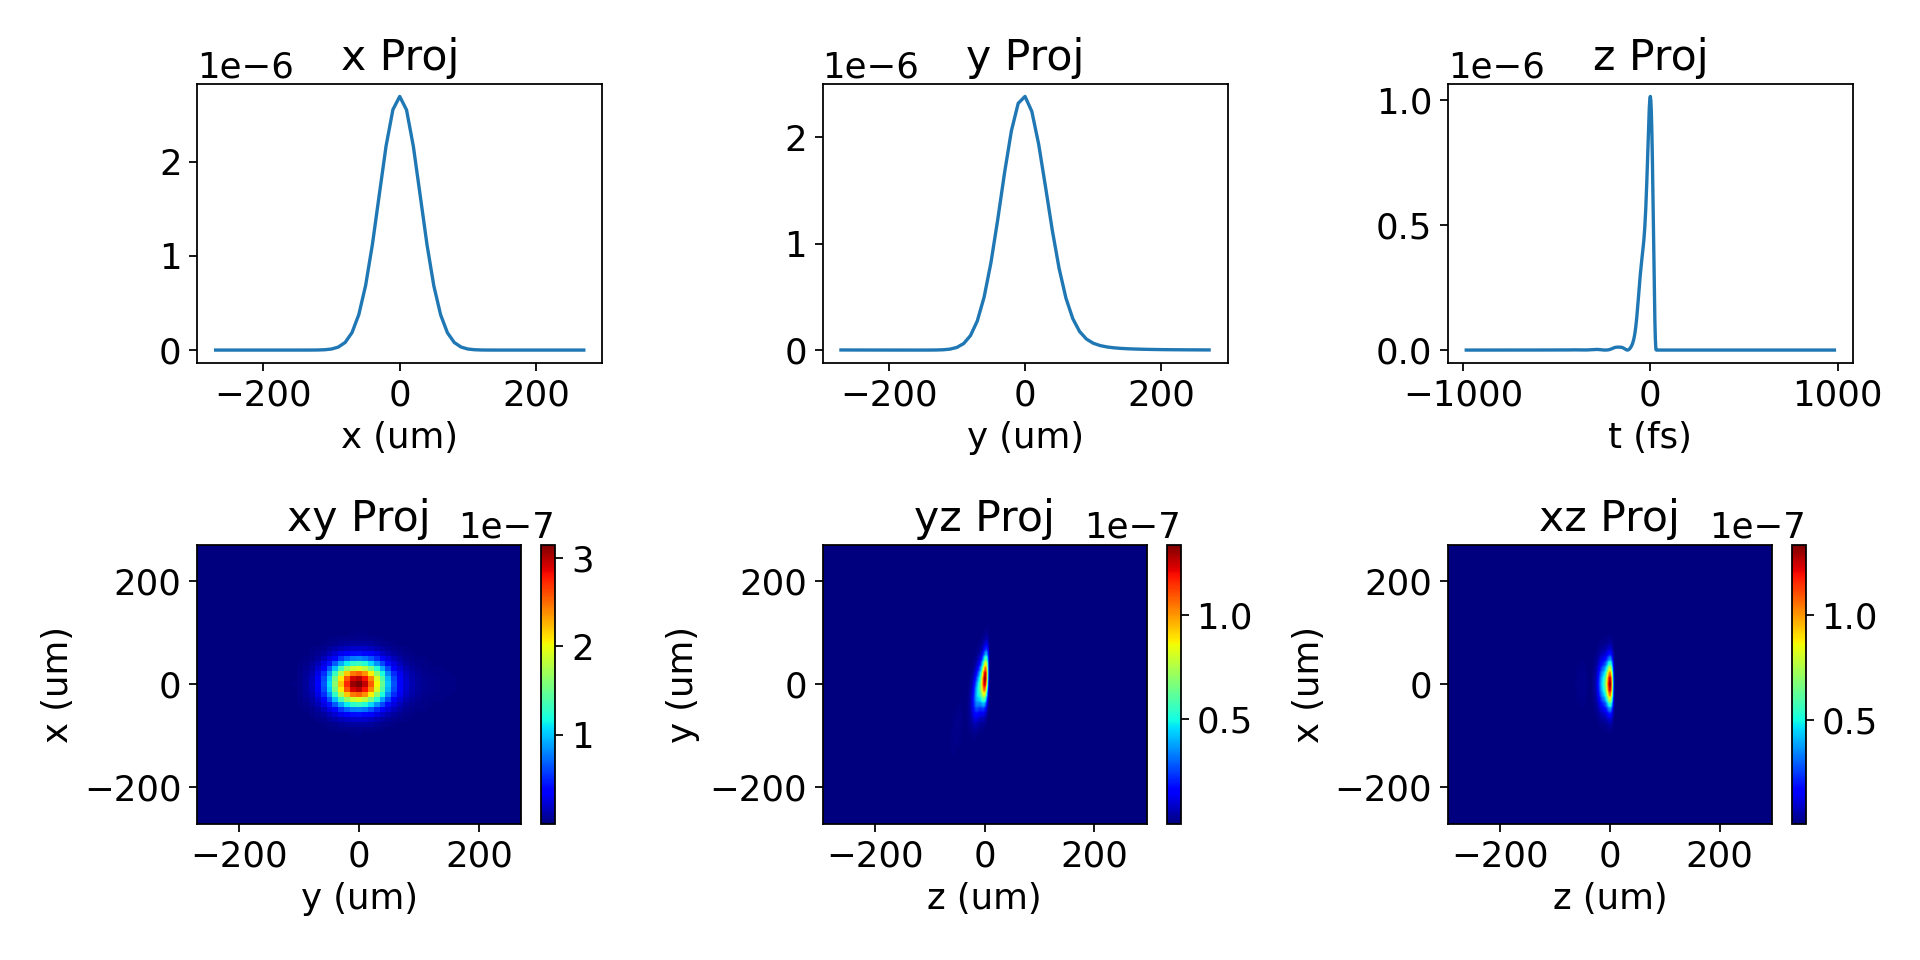

Plotting Electric Field Spectrum


<IPython.core.display.Javascript object>


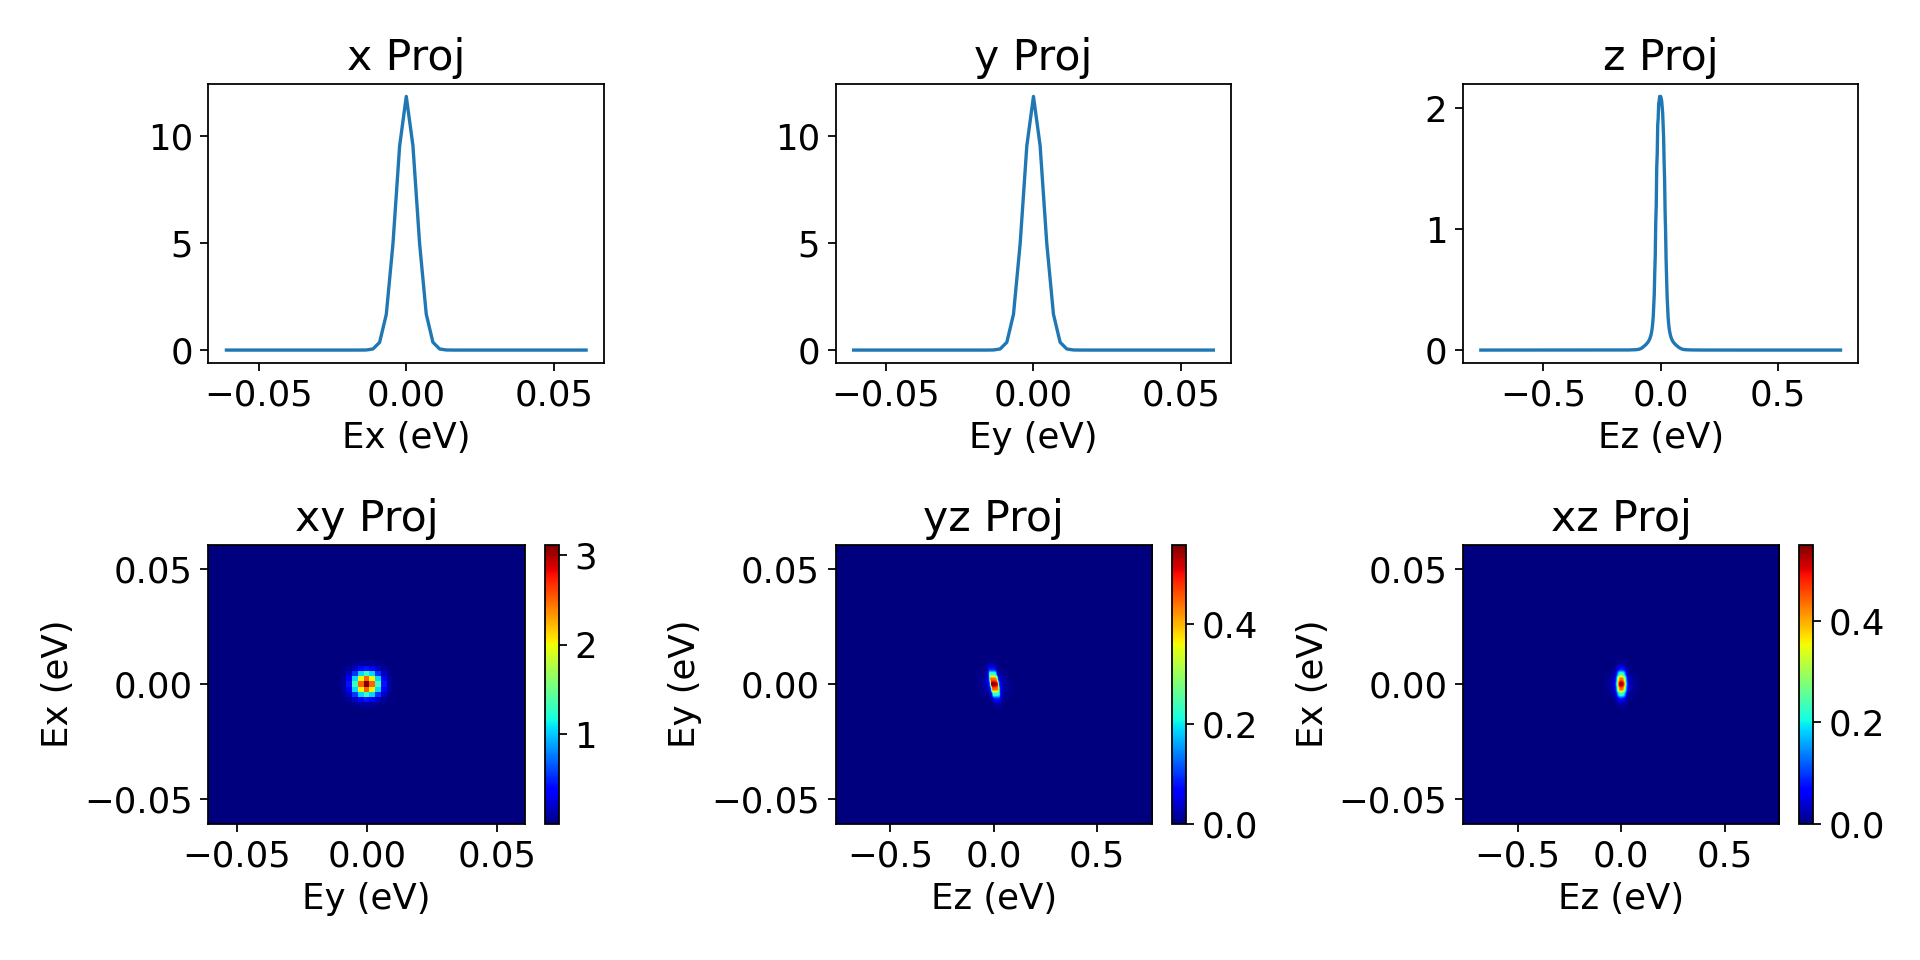

In [4]:
#setting up the crystals
crystalProperties = [
                     GetCrystalParam.getCrystalParam(CrystalType="Diamond", MillerIndex= "400", EnergyKeV=E0),
                     GetCrystalParam.getCrystalParam(CrystalType="Silicon", MillerIndex= "337", EnergyKeV=E0)
                    ]

# Initialize the crystal
myCrystals = [Crystal.CrystalBlock3D(h=np.array([0.0, np.pi * 2 / crystalProperties[0]['d'], 0.0]),
                                 normal=np.array([0., - 1.0, 0.0]),
                                 surface_point=np.zeros(3),
                                 thickness=10e6,
                                 chi_dict={"chi0": crystalProperties[0]['chi0'],
                                           "chih_sigma": crystalProperties[0]['chi_s'],
                                           "chihbar_sigma": crystalProperties[0]['chi_s'],
                                           "chih_pi": crystalProperties[0]['chi_s'],
                                           "chihbar_pi": crystalProperties[0]['chi_p'],}),
          Crystal.CrystalBlock3D(h=np.array([0.0, np.pi * 2 / crystalProperties[1]['d'], 0.0]),
                                 normal=np.array([0., - 1.0, 0.0]),
                                 surface_point=np.zeros(3),
                                 thickness=10e6,
                                 chi_dict={"chi0": crystalProperties[1]['chi0'],
                                           "chih_sigma": crystalProperties[1]['chi_s'],
                                           "chihbar_sigma": crystalProperties[1]['chi_s'],
                                           "chih_pi": crystalProperties[1]['chi_s'],
                                           "chihbar_pi": crystalProperties[1]['chi_p'],}),
         ]


# Define the incident wave-vector, with respect to which we will align the crystals
k0Vec = np.array([0.0, 0.0, k0])  # incident beam is along the z direction

# Align the 1st crystal
util.align_crystal_dynamical_bragg_reflection(crystal=myCrystals[0],
                                          kin=k0Vec,
                                          rot_direction=-1.,
                                          scan_range=0.0005,
                                          scan_number=10000)

# Get kout from the first crystal
k1Vec = util.get_bragg_kout(kin=k0Vec,
                        h=myCrystals[0].h,
                        normal=myCrystals[0].normal)


# Align the 2nd crystal
util.align_crystal_dynamical_bragg_reflection(crystal=myCrystals[1],
                                          kin=k1Vec,
                                          rot_direction=1.,
                                          scan_range=0.0005,
                                          scan_number=10000)

# Get the output wave-vector from all the crysatls
kOutArray = MultiDevice.get_kout(device_list=myCrystals,
                             kin=k0Vec)

# Get directions of the output wave-vectors
directions = kOutArray / util.l2_norm_batch(kOutArray)[:, np.newaxis]

# Define the distances between the first crystal and second crystal and the second crystal to the sample
distances = [1e6, 1e6]
distances[1] *=  np.sin(np.arccos(np.dot(directions[0], directions[1])))
distances[1] /=  np.sin(np.arccos(np.dot(directions[1], directions[2])) -
                    np.arccos(np.dot(directions[0], directions[1])))

# Define the location of the crystals
surfacePoint = np.zeros(3, dtype=np.float64)

surfacePoint = np.copy(surfacePoint)
myCrystals[0].set_surface_point(surface_point=np.copy(surfacePoint))

surfacePoint += directions[1] * distances[0]
myCrystals[1].set_surface_point(surface_point=np.copy(surfacePoint))

observation = np.copy(surfacePoint) + directions[2] * distances[1]

# Get the trajectory of the whole setup
(intersectionList,
kOutArray,
pathLength) = MultiDevice.get_lightpath(device_list=myCrystals,
                                     kin=k0Vec,
                                     initial_point=np.array([0.0, 0.0, - 1e6]),
                                     final_plane_point=observation,
                                     final_plane_normal=directions[-1])

intersectionArray = np.vstack(intersectionList)

# Get the rotation angle 
rotAngle = np.arccos(np.dot(directions[1], directions[2])) - np.arccos(np.dot(directions[0], directions[1]))
# Get the rotation matrix
rotMatrix = np.array([[1.0, 0.0, 0.0],
                  [0.0, np.cos(rotAngle), -np.sin(rotAngle)],
                  [0.0, np.sin(rotAngle),  np.cos(rotAngle)],
                 ])
# Rotation around the observation point, i.e. where the sample is
rotCenter = np.copy(observation)

# Rotate the crystals and the shift the position of every crystals
for crystal in myCrystals:
    crystal.shift(displacement=-observation)
    crystal.rotate(rot_mat = rotMatrix)

# Define the initial position of the pulse before the crystals
xInitial = np.array([0,0,-1e6]) - rotCenter
xInitial = np.dot(rotMatrix, xInitial)

k0VecRot = np.dot(rotMatrix, k0Vec)

# Get the reference wave vector
refWaveWec = np.dot(rotMatrix, kOutArray[2])

#  Get k gird to calculate the reflectivity and get the output pulse
kVecGridInitial = np.zeros((nx, ny, nz, 3), dtype=np.float64)
kVecGridInitial[:,:,:,0] = kxCoor[:, np.newaxis, np.newaxis]
kVecGridInitial[:,:,:,1] = kyCoor[np.newaxis, :, np.newaxis]
kVecGridInitial[:,:,:,2] = kzCoor[np.newaxis, np.newaxis, :]

# Make it flat
kVecGridInitial = np.reshape(kVecGridInitial, (nx * ny * nz, 3))

# Get the rotated grid
kVecGridInitial = np.dot(rotMatrix, kVecGridInitial.T).T
kVecGridInitial = np.ascontiguousarray(kVecGridInitial)

#  Prepare the spectrum
eSpectrumAfterLens2 = np.reshape(eSpectrumAfterLens2, nx * ny * nz)
eSpectrumAfterLens = np.ascontiguousarray(eSpectrumAfterLens2)

#################################################################
# Split the array
#################################################################
# Number of batches
batchNum = 10

# split the arrays
kVecGridList = np.array_split(kVecGridInitial, batchNum, axis=0)
spectrumList = np.array_split(eSpectrumAfterLens, batchNum)

specHolder = list(range(batchNum))
reflectivityHolder = list(range(batchNum))
sanityCheck = list(range(batchNum))

# Loop through all the batches
for idx in range(batchNum):

    # Get the time
    tic = time.time()

    (specHolder[idx],
     reflectivityHolder[idx],
     sanityCheck[idx]
    ) = GPUMultiDevice.get_diffraction_spectrum_sigma_full(
        kin_grid=kVecGridList[idx],
        spectrum_in=spectrumList[idx],
        device_list=myCrystals,
        total_path=pathLength,
        initial_position = xInitial,
        d_num=512)

    # Get the time
    toc = time.time()
#     print("It takes {:.2f} seconds to get the field for batch {}.".format(toc - tic, idx))
koutArray = np.concatenate([sanityCheck[x]['kout_grid'] for x in range(batchNum)])
koutArray = np.reshape(koutArray, (nx, ny, nz, 3))

eSpectrumAfterCrystals = np.concatenate([specHolder[x]['final_spectrum'] for x in range(batchNum)])
eSpectrumAfterCrystals = np.reshape(eSpectrumAfterCrystals, (nx, ny, nz))

eFieldAfterCrystals = np.fft.ifftn(np.fft.ifftshift(eSpectrumAfterCrystals))
# get the statistics
eFieldAfterCrystals = rollEfield(eFieldAfterCrystals, ny, nz)
eFieldAfterCrystalsStatistics = misc.get_statistics(np.square(np.abs(eFieldAfterCrystals)))
eSpectrumAfterCrystalsStatistics = misc.get_statistics(np.square(np.abs(eSpectrumAfterCrystals)))

nz_crop = 3**6 # crop the spectrum in the z direction as it is very narrow
eFieldAfterCrystals_crop, eSpectrumAfterCrystals_crop, nz_crop, dz_crop, EzCoor_crop,tCoor_crop = crop_spectrum(eSpectrumAfterCrystals, nz,dz,k0,nz_crop)
zCoor_crop = tCoor_crop * util.c
# get the statistics
eFieldAfterCrystals_crop = rollEfield(eFieldAfterCrystals_crop, ny, nz_crop)

eFieldAfterCrystalsStatistics_crop = misc.get_statistics(np.square(np.abs(eFieldAfterCrystals_crop)))
eSpectrumAfterCrystalsStatistics_crop = misc.get_statistics(np.square(np.abs(eSpectrumAfterCrystals_crop)))
plotting_e_beam(eFieldAfterCrystalsStatistics_crop, eSpectrumAfterCrystalsStatistics_crop, xCoor, yCoor, zCoor_crop, tCoor_crop, ExCoor, EyCoor, EzCoor_crop)

# coherece factor calculation

In [5]:
sam_t = 44. #sample thickness
dsz = 1. #resolution for calculating coherence factor integration in z direction
nSampleZ = int(sam_t/dsz)

th = util.get_bragg_angle(wavelength0, crystalProperties[1]['d']) - util.get_bragg_angle(wavelength0, crystalProperties[0]['d'])
qVec1 = kOutArray[0] - kOutArray[-1]
qVec2 = np.dot(np.linalg.inv(rotMatrix), qVec1)
Q = np.linalg.norm(qVec2)
tic = time.time()
#compute numerator of coherence factor
gamma_t = GPUContrast.getGammaT(eFieldAfterCrystals_crop, 
                            qVec=qVec2,
                            k0=k0,
                            nx=nx,
                            ny=ny,
                            nz=nz_crop,
                            dx=dx,
                            dy=dy,
                            dz=dz_crop,
                            dsz = dsz,
                            nSampleZ=nSampleZ)

toc = time.time()
print("It takes {:.2f} seconds to finish the calculation".format(toc - tic))
#compute denominator of coherence factor
gamma_0 = 0
for i in range(nx):
    for j in range(ny):
        gamma_0 += np.abs(np.mean(np.conjugate(eFieldAfterCrystals_crop[i,j,:])*eFieldAfterCrystals_crop[i,j,:]))
gamma_0 /= (nx*ny)
gamma_0 = np.square(gamma_0)
beta =gamma_t/gamma_0/float((nx*ny*nSampleZ)**2)
print ("thickness:{}, contrast:{}".format(sam_t, beta))

It takes 43.40 seconds to finish the calculation
thickness:44.0, contrast:0.4391996069155803
